# 1. Import Dependencies

In [1]:
import os

import cv2
import numpy as np
import pandas as pd
import skimage as ski

print(f"Pandas {pd.__version__}\tNumpy {np.__version__}\t")

Pandas 2.1.1	Numpy 1.24.3	


# 2. Data Preparation

In [21]:
new_height = 128
new_width = 128

faces_df = pd.read_csv("../../datasets/faces/faces.csv")

NUM_SAMPLES = int(faces_df.shape[0] * 1)

feature_vector: list = []
target_vector: list = []

HOG = cv2.HOGDescriptor(
    [128, 128],  # Window size
    [16, 16],  # Block size
    [16, 16],  # Block stride
    [8, 8],  # Cell size
    9  # Number of bins
)
 
for index, row in faces_df.iterrows():

    img_path = os.path.join("../../datasets/faces/images/", f"{row['image_name']}")

    gray_img = cv2.imread(img_path, flags=cv2.IMREAD_GRAYSCALE)

    x0, y0, x1, y1 = row['x0'], row['y0'], row['x1'], row['y1']
    
    original_height, original_width = gray_img.shape[:2]

    width_reduction_ratio = (new_width / original_width)
    height_reduction_ratio = (new_height / original_height)

    x0_new = int(x0 * width_reduction_ratio)
    y0_new = int(y0 * height_reduction_ratio)

    x1_new = int(x1 * width_reduction_ratio)
    y1_new = int(y1 * height_reduction_ratio)

    hog = HOG.compute(cv2.resize(gray_img, (new_width, new_height)))

    feature_vector.append( hog / hog.max() )
    target_vector.append([x0_new, y0_new, x1_new, y1_new])

    if index == NUM_SAMPLES - 1:
        break

In [22]:
print(f"feature_vector is a vector of {len(feature_vector)} arrays, each array is around {len(feature_vector[np.random.randint(0, NUM_SAMPLES)])} elements long")
print(f"target_vector is a vector of {len(target_vector)} arrays, each array is 4 elements long")

feature_vector is a vector of 3350 arrays, each array is around 2304 elements long
target_vector is a vector of 3350 arrays, each array is 4 elements long


# 3. Data Split

In [23]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(feature_vector, target_vector, test_size=0.2, random_state=42)

# 4. Training

In [24]:
from sklearn.linear_model import LinearRegression

face_detector_model = LinearRegression().fit(x_train, y_train)

# 5. Evaluation

In [29]:
from sklearn.metrics import mean_squared_error

y_predicted = face_detector_model.predict(x_test)

mse = mean_squared_error(y_test, y_predicted)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 5399314.891422797


# 6. Image Testing

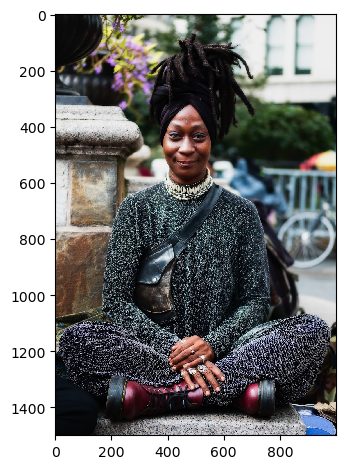

In [30]:
test_image = ski.io.imread("../../datasets/faces/images/00000023.jpg")

test_feature = HOG.compute(cv2.resize(test_image, (new_width, new_height)))

[[Xmin, Ymin, Xmax, Ymax]] = face_detector_model.predict([test_feature / test_feature.max()])

width_expansion_ratio = test_image.shape[0] / new_width
height_expansion_ratio = test_image.shape[1] / new_height

rr, cc = ski.draw.rectangle(start=(Xmin * width_expansion_ratio, Ymin * height_expansion_ratio),
                            end=(Xmax * width_expansion_ratio, Ymax * height_expansion_ratio),
                            shape=(test_image.shape[0], test_image.shape[1]))

test_image[:,:,1][rr, cc] = 255

ski.io.imshow(test_image)
ski.io.show()

In [45]:
# Open the default camera (camera index 0)
camera = cv2.VideoCapture(0)

while camera.isOpened():
    # Capture frame-by-frame
    ret, frame = camera.read()

    grayscale_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    gamma_corrected_frame = np.uint8(np.power(frame / 255, 0.4) * 255)

    cv2.imshow('Video',)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Release the video capture object and close the window
camera.release()
cv2.destroyAllWindows()